In [3]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
from utility import *

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacsvis import circuit_drawer

#  変分法を用いて量子演算を特定の演算で分解する
- エンタングルメント状態の生成
- エンタングルメント忠実度の計算
- `ParametericQuantumCircuit` クラスを使う

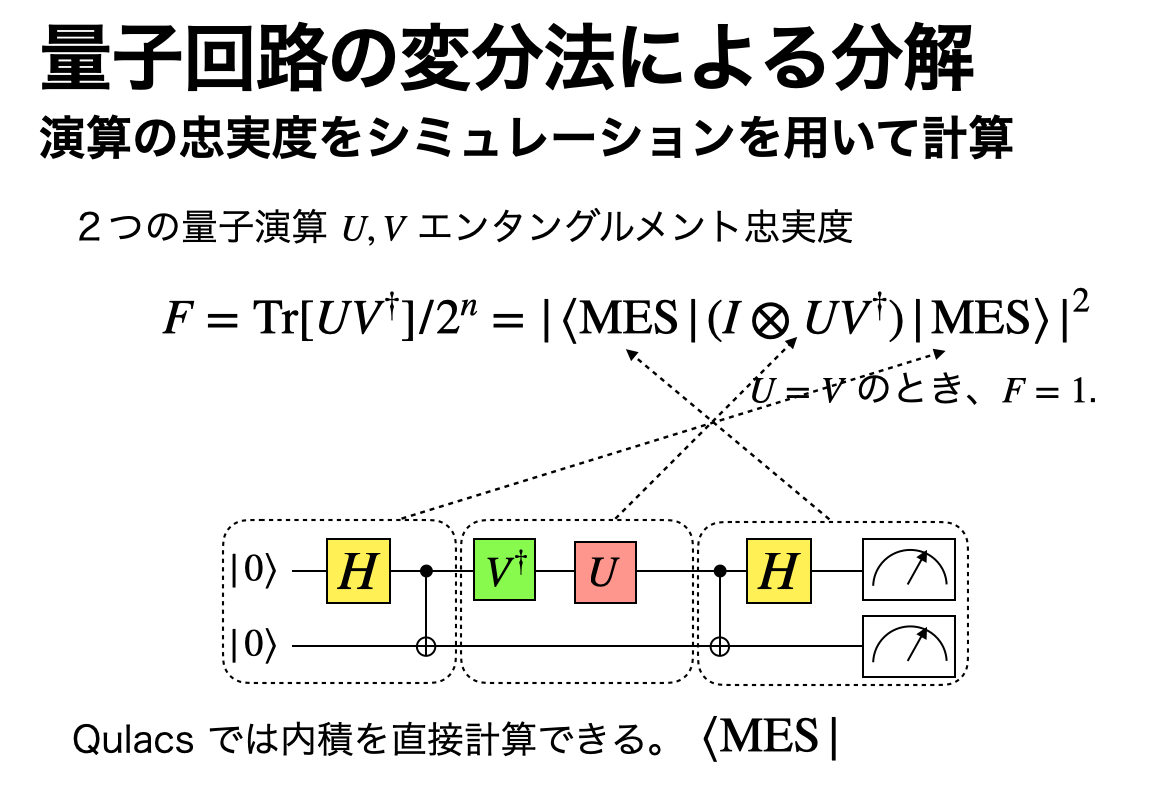

In [5]:
from IPython.display import Image
Image("./fujii_fig01.png",width = 600)

## 最大エンタングル状態の生成

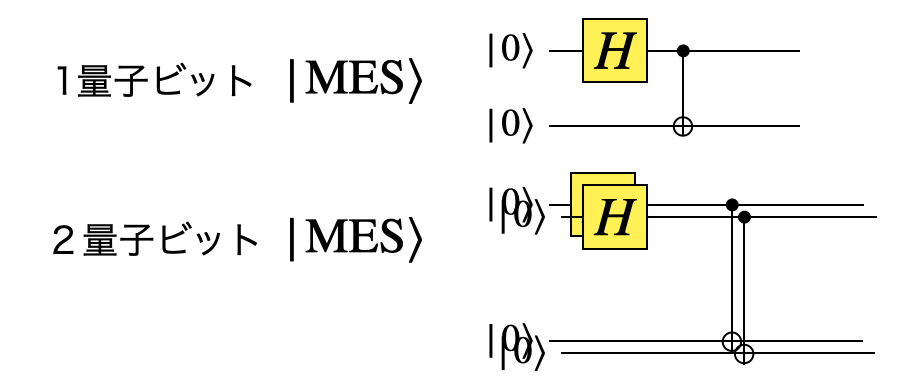

In [6]:
Image("./fujii_fig02.png",width = 600)

In [7]:
nqubits = 2
mes = QuantumState(nqubits)
H(0).update_quantum_state(mes)
CNOT(0,1).update_quantum_state(mes)

0,1基底での確率分布は、

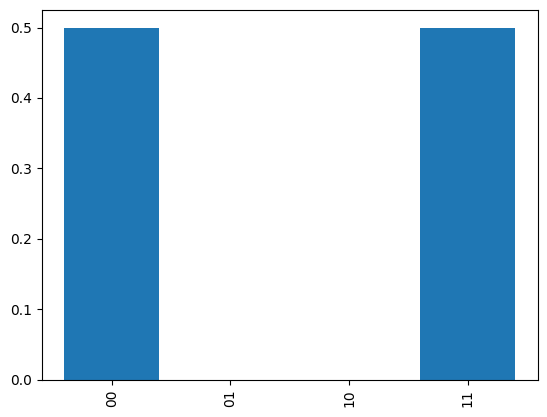

In [8]:
show_distribution(mes)

$\{ |+\rangle , |-\rangle \} $基底での測定は、$H$を作用させてから0,1測定すればいいので

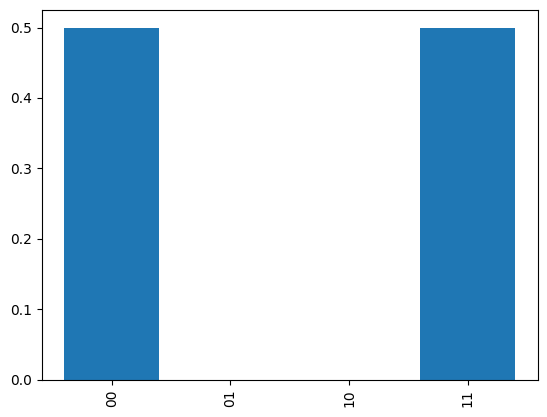

In [9]:
H(0).update_quantum_state(mes)
H(1).update_quantum_state(mes)
show_distribution(mes)

基底を変えても完全相関があることがわかる。2n qubitの最大エンタングル状態を生成する関数を作っておく。

In [10]:
def maximally_entangled_state(nqubits):
    state = QuantumState(2*nqubits)
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        CNOT(i,i+nqubits).update_quantum_state(state)
    return state

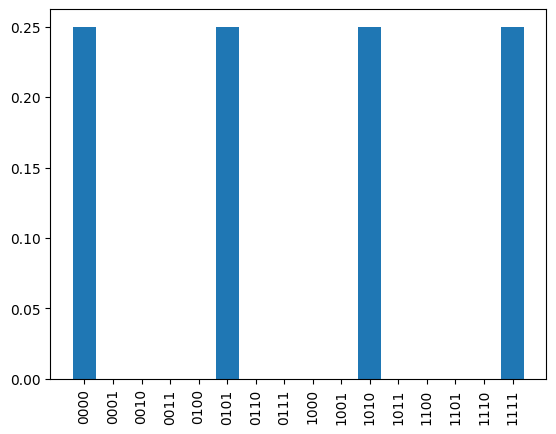

In [11]:
four_qubit_mes = maximally_entangled_state(2)
show_distribution(four_qubit_mes)

## エンタングルメント忠実度を計算する

`RandomUnitary`を用いてターゲットとなるランダムな量子演算を作っておく

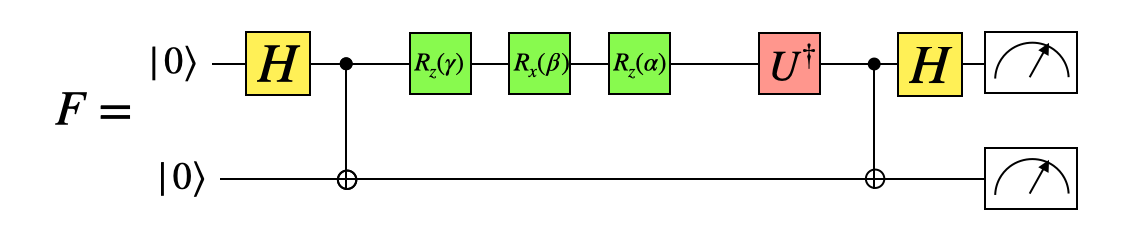

In [12]:
Image("./fujii_fig02b.png",width = 600)

In [13]:
from qulacs.gate import RandomUnitary
target_list = [0]
target_unitary = RandomUnitary(target_list)
print(target_unitary)

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
 (0.730061,-0.207663)   (0.638504,0.127274)
  (0.457701,0.463029) (-0.228458,-0.723823)



パラメータ付きの量子回路を`ParametricQuantumCircuit`に`add_parametric_RX_gate`で追加する生成する

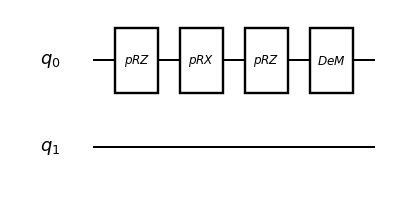

In [14]:
nqubits = 2 # 2qubitの空間考えているので2qubit分確保しておく

#パラメータ付きの量子回路クラス
ansatz = ParametricQuantumCircuit(nqubits)

#パラメータを回路構成後に変更できる演算
ansatz.add_parametric_RZ_gate(0,0.0)
ansatz.add_parametric_RX_gate(0,0.0)
ansatz.add_parametric_RZ_gate(0,0.0)

#通常の量子演算
ansatz.add_gate(target_unitary)

#量子回路の可視化
circuit_drawer(ansatz, "mpl")

エンタングルメント忠実度を計算する。`mes_copy` = $\langle \text{MES}|$, `mes` = $I \otimes (U^{\dagger} R_z(\alpha) R_x(\beta) R_z(\gamma))|\text{MES}\rangle$として、`inner_product`関数を実行

In [15]:
mes = maximally_entangled_state(1)
mes_copy = mes.copy()
ansatz.update_quantum_state(mes)

from qulacs.state import inner_product
ent_fidelity = abs(inner_product(mes_copy,mes))**2
print(ent_fidelity)

0.279817995782748


エンタングルメント忠実度を計算する関数を作っておく

In [16]:
from qulacs.state import inner_product

def entanglement_fidelity(ansatz,nqubits):
    mes = maximally_entangled_state(int(nqubits/2))
    mes_copy = mes.copy()
    ansatz.update_quantum_state(mes)

    ent_fidelity = abs(inner_product(mes_copy,mes))**2
    return ent_fidelity

In [17]:
entanglement_fidelity(ansatz,2)

0.279817995782748

## 忠実度を最適化することで、演算の分解を見つける

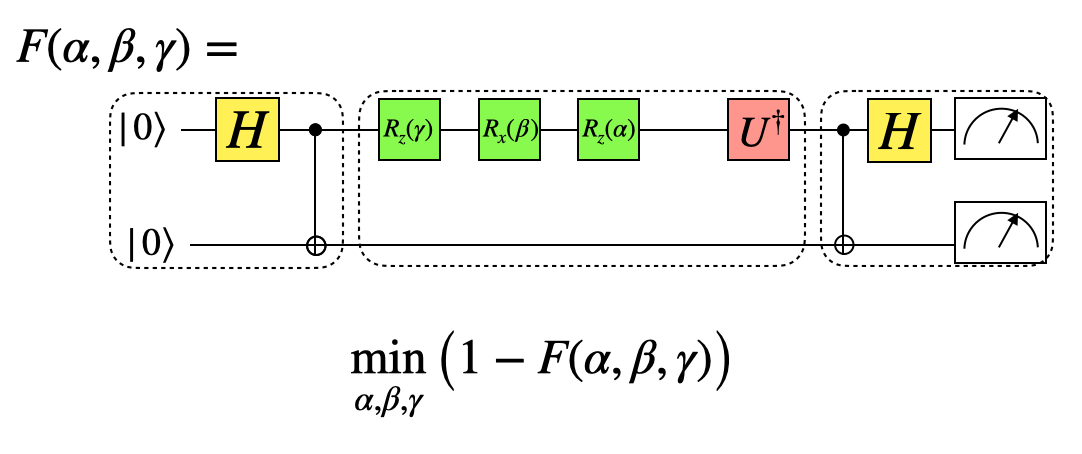

In [18]:
Image("./fujii_fig02c.png",width = 600)

パラメータ付き回路のパラメータを変化させて、ターゲットの量子演算となるパラメータを見つけよう。i番目のパラメータの変更は、`set_parameter(i,new_parameter)`

In [19]:
def cost(parameters):
    num_paras = ansatz.get_parameter_count()

    #パラメータを変更
    for i in range(num_paras):
        ansatz.set_parameter(i,parameters[i])
    
    return 1 - entanglement_fidelity(ansatz,nqubits)

In [20]:
cost([random.random() for i in range(3)])

0.9105093927112391

scipyの最適化関数をつかって、パラメータを変分的に最適化しよう

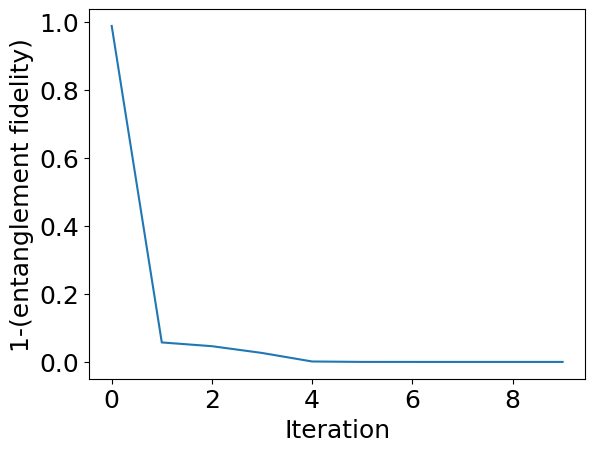

In [21]:
import scipy.optimize

cost_history = []

#パラメータの初期値
init_theta_list = [random.random() for i in range(ansatz.get_parameter_count())]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("1-(entanglement fidelity)")
plt.show()

In [22]:
print("fidelity",opt.fun,"parameters",opt.x)


fidelity 4.3253178816371474e-11 parameters [2.63910172 1.41796404 2.04467989]


In [23]:
cost([-0.1523479  , 2.03515578,-2.1503557 ])

0.9976341047597013

できた回路が同じであることを確認しておく（エルミート共役をとるので、パラメータの順序を逆にし、マイナスをつけることを忘れない）
$$
(R_z(\alpha) R_x(\beta) R_z(\gamma))^{\dagger} = R_z(-\gamma) R_x(-\beta) R_z(-\alpha))
$$

In [24]:
nqubits = 1
state0 = QuantumState(nqubits)
state0.set_Haar_random_state()
state1 = state0.copy()

target_unitary.update_quantum_state(state0)

RZ(0,-1.0*opt.x[2]).update_quantum_state(state1)
RX(0,-1.0*opt.x[1]).update_quantum_state(state1)
RZ(0,-1.0*opt.x[0]).update_quantum_state(state1)

abs(inner_product(state0,state1))**2


0.9999999999611422

（全体の位相因子が異なる場合がある。）

## 応用編：CNOT演算を分解する
2量子ビット以上のパウリの回転演算子は`add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, angle)`
で追加できる。`pauli_id_list`はX、Y、Z、をそれぞれ1,2,3として並べたリスト。


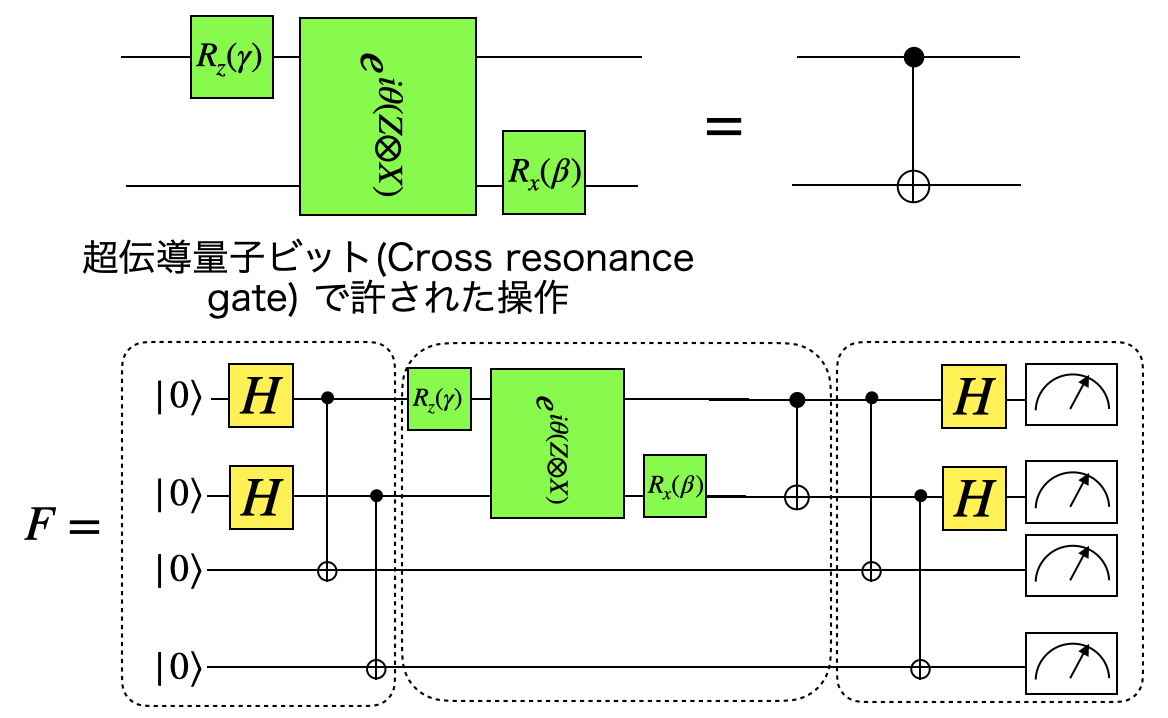

In [25]:
Image("./fujii_fig03.png",width = 600)

パウリ行列$I=\sigma_0, X=\sigma_1, Y=\sigma_2, Z=\sigma_3$の添え字(0-3)をqulacsでは`pauli_id`と呼んでいる。  
`add_parametric_multi_Pauli_rotation_gate`関数の引数は次の通り。

- `index_list`: 量子ビットのインデックスのリスト
- `pauli_ids`: $e^{i\theta U}$の$U$を$U$をパウリ行列のテンソル積するときの、`pauli_id`のリスト。例えば、$Z \otimes X = \sigma_3 \otimes \sigma_1$の場合は、`[3,1]`
- `angle`: $e^{i\theta U}$の$\theta$

`index_list`と`pauli_ids`の長さは同じにする。

In [26]:
nqubits = 4 # 4qubitの空間考えているので4qubit分確保しておく

#パラメータ付きの量子回路クラス
ansatz = ParametricQuantumCircuit(nqubits)

#パラメータを回路構成後に変更できる演算
ansatz.add_parametric_RZ_gate(0,0.0)
ansatz.add_parametric_multi_Pauli_rotation_gate([0,1],[3,1], 0.0)
ansatz.add_parametric_RX_gate(1,0.0)

#ターゲットの量子演算
ansatz.add_gate(CNOT(0,1))

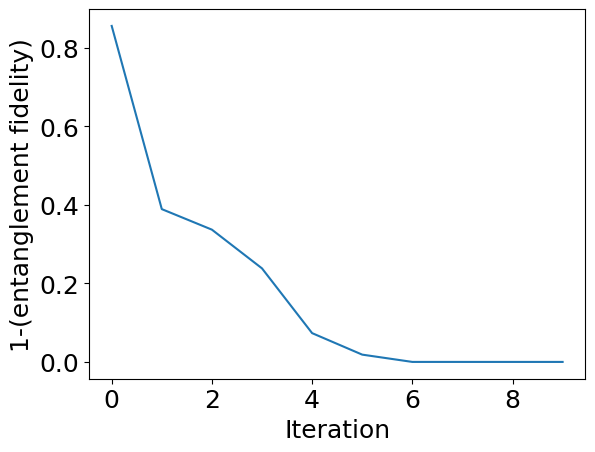

In [27]:
cost_history = []

#パラメータの初期値
init_theta_list = [random.random() for i in range(ansatz.get_parameter_count())]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("1-(entanglement fidelity)")
plt.show()

In [28]:
opt.x

array([ 1.57078545, -1.57080084,  1.57079334])